# Sentinel 2
### Eleonora (Nori) Parelius
### 20.10.2025

Before we go any further, if you are in Google Colab, go to **File -> Save a copy in Drive**. This will create a personal copy you can freely edit. So feel free to take notes here and modify the code. If you don't save a copy in your Drive though, your changes will disappear when you close the session.

# Sentinel 2
* go to [wiki page on Sentinel 2 at Copernicus](https://sentiwiki.copernicus.eu/web/s2-mission)
* skim for 5 minutes and try to identify 3-5 key characteristics of Sentinel 2
* optionally, identify one question you think the text can answer

# Sentinel 2
* Part of European Space Agency's (ESA) Copernicus programme
* Twin sattelites
    * Sentinel 2A since 23. June 2015
    * Sentinel 2B since 7. March 2017
    * Sentinel 2C, launched on 5.9.2024 -- to replace 2A
    
<img src="https://github.com/nori-parelius/Sentinel2Intro/blob/main/images/sentinelsat.jpg?raw=1" alt="Image of Sentinel 2 from Copernicus" width="400"/>

## Coverage and time resolution
* At same angle every 5 days (10 days for same sattelite)
* Between $56^{\circ}$ S and $84^{\circ}$ degrees N
* Coast up to 20 km from land
* Islands over $100\ \rm{km^2}$
* Antarctica on demand
* Sun synchronous orbit at 786 km, 10:30 am descending node
<img src="https://github.com/nori-parelius/Sentinel2Intro/blob/main/images/sentinelcoverage.png?raw=1" alt="Coverage of Sentinel 2" width="400"/>  
Image from Copernicus

## Sentinel 2 multispectral sensor
* 13 spectral bands in VIS, VNIR, SWIR
* Spatial resolution 10, 20, 60 m
* Push-broom, swath of 290 km
![](https://github.com/nori-parelius/Sentinel2Intro/blob/main/images/sentinelbands.jpg?raw=1)

Image from eoportal.org


## Sentinel tiles
<img src="https://github.com/nori-parelius/Sentinel2Intro/blob/main/images/S2_granules_tiles.jpg?raw=1" alt="Sentinel 2 tiles vs granules" width="300"/>

Image from eox.at

## Products
All free!

* Level-1B
    * Top-of-atmosphere calibrated radiances in sensor geometry
    * Include radiometric corrections
    * Not orthorectified
    * Come in granules
* Level-1C
    * Top-of-atmosphere reflectance
    * Radiometrically and geometrically corrected
    * Orthorectified and spatially coregistered on a global reference system.
    * Come in tiles
* Level-2A
    * Bottom-of-atmosphere (Surface) reflectance
    * Otherwise same as L-1C

## Examples

Let's look at the [Copernicus browser](https://browser.dataspace.copernicus.eu/)

## Normalized difference vegetation index (NDVI)

$$NDVI = \frac{B8\ (NIR)-B4\ (red)}{B8+B4}$$

![](https://github.com/nori-parelius/Sentinel2Intro/blob/main/images/reflectance.jpg?raw=1)

# Sentinel 2 - Searching, downloading, loading up and working with it in Python

In [1]:
!pip install rasterio matplotlib numpy pyproj shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 33.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm


## The question

First half of 2022, there was a drought in Norway, so we could expect that the vegetation in 2022 wasn't as healthy as usual. This should show up by NDVI being generally lower in 2022 than in 2021.

The plan is to 
- download one image from the same month each year
- calculate NDVI for each of them
- compare 

## Get the images
- go to [Copernicus browser](https://browser.dataspace.copernicus.eu/)
- sign in (you have to be signed in to download)
- pick your area (I am picking my home :))
- draw the area of interest using the tools on the right side of the screen
- note down the corner coordinates of your area of interest (they show up on the bottom of the map when you hover over)
- use the *Search* tab in the left pane
    - choose the right platform, image product and cloud coverage
    - define time period as May 2021
    - click on search
- choose an image that looks good
- download it
- repeat for 2022

## Check the files
Where are the images? Unzip and explore the folder structure.

## Adding the files to Colab
- open your Google Drive
- make a folder called "S2Intro-data"
- upload the two .SAFE folders into it
- mount your drive to google colab with the following command

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

The folder structure of Sentinel 2 data is a little convoluted and the filenames are long. To avoid having to copy/paste the names, which is error prone, we load them by listing the contents of the folders.

In [13]:
data_dir = '/content/drive/MyDrive/S2Intro-data/'
may_2021_dir = [f.path for f in os.scandir(data_dir) if '.SAFE' in f.name and '202105' in f.name][0]
may_2022_dir = [f.path for f in os.scandir(data_dir) if '.SAFE' in f.name and '202205' in f.name][0]
print(may_2021_dir)
print(may_2022_dir)

/content/drive/MyDrive/S2Intro-data/S2B_MSIL2A_20210530T104619_N0500_R051_T32VPM_20230228T112003.SAFE
/content/drive/MyDrive/S2Intro-data/S2A_MSIL2A_20220517T103631_N0400_R008_T32VPM_20220517T161111.SAFE


In [ ]:
# Function to find files with specific strings in the filename
# Which strings do you think we need to find the different band files?
def find_file(root_folder, str_list):
  """
  Find a file in a folder (and its subfolders) that contains all strings in str_list in its filename.
  Returns the full path to the file.
  """
  for root, dirs, files in os.walk(root_folder):
    for filename in files:
      if all(x in filename for x in str_list):
        return os.path.join(root, filename)


/content/drive/MyDrive/S2Intro-data/S2B_MSIL2A_20210530T104619_N0500_R051_T32VPM_20230228T112003.SAFE/GRANULE/L2A_T32VPM_A022099_20210530T104621/IMG_DATA/R20m/T32VPM_20210530T104619_B02_20m.jp2


In [ ]:
print(find_file(may_2021_dir, ['2021','B02', 'jp2']))

In [ ]:
import rasterio

# Open bands 2, 3, 4 and 8

# 2021
m2021_band2=rasterio.open(find_file(may_2021_dir, ['2021','B02', 'jp2']))
m2021_band3=rasterio.open(find_file(may_2021_dir, ['2021','B03', 'jp2']))
m2021_band4=rasterio.open(find_file(may_2021_dir, ['2021','B04', 'jp2']))
m2021_band8=rasterio.open(find_file(may_2021_dir, ['2021','B08', 'jp2']))

2022
m2022_band2=rasterio.open(find_file(may_2022_dir, ['2022','B02', 'jp2']))
m2022_band3=rasterio.open(find_file(may_2022_dir, ['2022','B03', 'jp2']))
m2022_band4=rasterio.open(find_file(may_2022_dir, ['2022','B04', 'jp2']))
m2022_band8=rasterio.open(find_file(may_2022_dir, ['2022','B08', 'jp2']))



{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'), 'transform': Affine(20.0, 0.0, 600000.0,
       0.0, -20.0, 6700020.0), 'blockxsize': 640, 'blockysize': 640, 'tiled': True}


In [ ]:
# Check the properties of one of the bands
print(m2021_band2.profile)
# You can check the others too

## Plotting the bands

In [ ]:
# Fill in the blanks
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(m2022_band4.read(1), cmap='Reds')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(..., cmap='Greens')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(..., cmap='Blues')

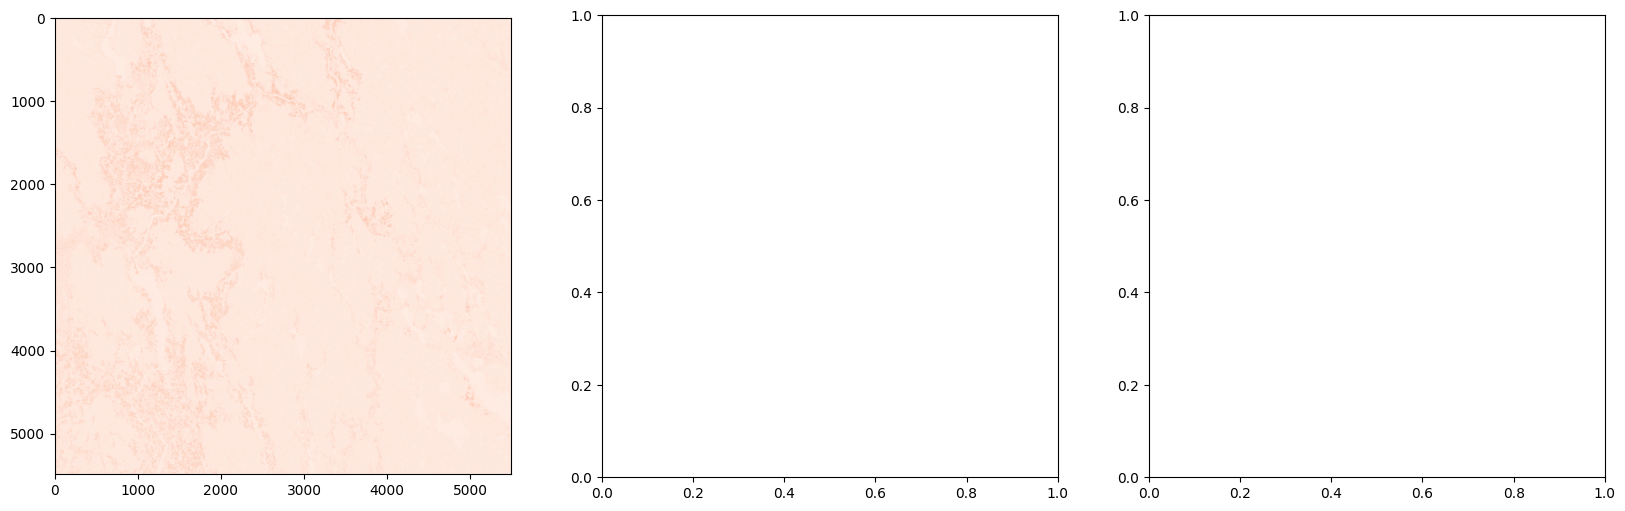

In [24]:
##
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(m2022_band4.read(1), cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
#ax1.imshow(m2022_band3.read(1), cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
#ax1.imshow(m2022_band2.read(1), cmap='Blues')

## Plotting the RGB
That comes with the granule

In [32]:
from rasterio.plot import show
#RGB_im = rasterio.open('/content/drive/MyDrive/data/S2A_MSIL2A_20220517T103631_N0400_R008_T32VPM_20220517T161111.SAFE/S2A_MSIL2A_20220517T103631_N0400_R008_T32VPM_20220517T161111-ql.jpg')
RGB_thumbnail_file = find_file(may_2022_dir, ['.jpg'])
print(RGB_thumbnail_file)
RGB_thumbnail = rasterio.open(RGB_thumbnail_file)
# What do you get when you look at the properties?

/content/drive/MyDrive/S2Intro-data/S2A_MSIL2A_20220517T103631_N0400_R008_T32VPM_20220517T161111.SAFE/S2A_MSIL2A_20220517T103631_N0400_R008_T32VPM_20220517T161111-ql.jpg


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [33]:
print(RGB_thumbnail.profile)

{'driver': 'JPEG', 'dtype': 'uint8', 'nodata': None, 'width': 343, 'height': 343, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 343, 'blockysize': 1, 'tiled': False, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}


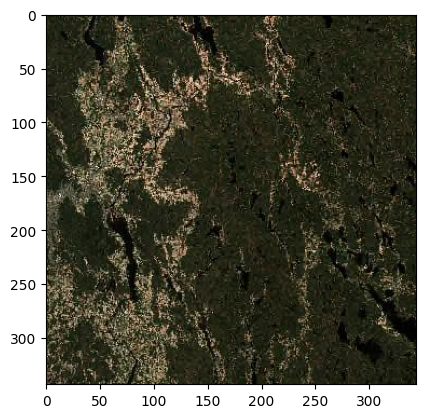

<Axes: >

In [34]:
show(RGB_thumbnail)

## Limiting the area

### Define the polygon

In [26]:
import shapely
import pyproj
from shapely.ops import transform

# bounding box coordinates of the area of interest in
# WGS84 CRS, [minx, miny, maxx, maxy]
bbox_coords = [60, 11.35, 60.21, 11.8] # find your for example

# Let's create a shapely geometry of the bounding box
polygon = shapely.geometry.box(*bbox_coords)
# what happens if you remove the asterisk?

# Get it into the right coordinate system
project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'), # source coordinate system
    pyproj.Proj('epsg:32632')) # destination coordinate system
# ! make sure you change to your destination coordinate system!

transformed_polygon = transform(project.transform, polygon)  # apply projection

### Crop all the bands and save as one tif

In [28]:
import rasterio.mask
out_band2, out_transform = rasterio.mask.mask(m2021_band2,
                                              [transformed_polygon],
                                              crop=True)
out_meta = m2021_band2.meta

out_meta.update({"driver": "GTiff",
                 "count" : 4,
                 "height": out_band2.shape[1],
                 "width": out_band2.shape[2],
                 "transform": out_transform})

out_band3,_ = rasterio.mask.mask(m2021_band3, [transformed_polygon], crop=True)
out_band4,_ = rasterio.mask.mask(m2021_band4, [transformed_polygon], crop=True)
out_band8,_ = rasterio.mask.mask(m2021_band8, [transformed_polygon], crop=True)

with rasterio.open("/content/drive/MyDrive/data/may2021_r10_masked.tif", "w", **out_meta) as dest:
    dest.write(out_band2.squeeze(),1)
    dest.write(out_band3.squeeze(),2)
    dest.write(out_band4.squeeze(),3)
    dest.write(out_band8.squeeze(),4)

Do the same for 2022

In [29]:
##
# same for 2022
out_band2, out_transform = rasterio.mask.mask(m2022_band2,
                                              [transformed_polygon],
                                              crop=True)
out_meta = m2022_band2.meta

out_meta.update({"driver": "GTiff",
                 "count" : 4,
                 "height": out_band2.shape[1],
                 "width": out_band2.shape[2],
                 "transform": out_transform})

out_band3, out_transform = rasterio.mask.mask(m2022_band3, [transformed_polygon], crop=True)
out_band4, out_transform = rasterio.mask.mask(m2022_band4, [transformed_polygon], crop=True)
out_band8, out_transform = rasterio.mask.mask(m2022_band8, [transformed_polygon], crop=True)

with rasterio.open("/content/drive/MyDrive/data/may2022_r10_masked.tif", "w", **out_meta) as dest:
    dest.write(out_band2.squeeze(),1)
    dest.write(out_band3.squeeze(),2)
    dest.write(out_band4.squeeze(),3)
    dest.write(out_band8.squeeze(),4)

## Let's plot it as RGB

In [31]:
img1 = rasterio.open("/content/drive/MyDrive/data/may2021_r10_masked.tif")
rgb_image1 = np.array([img1.read(3), img1.read(2), img1.read(1)])
# Values in optical bands come in digital units DN,
# where DN = 10 000 * reflectance where reflectance is 0-1
# Note, there is an offset of 1000 that is added to DNs
# to avoid negative numbers.
# https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
# Using 3 to brighten the images

print(np.unique(rgb_image1))

rgb_image1=(rgb_image1-1000.0)/10000*3
rgb_image1[rgb_image1>1]=1
rgb_image1[rgb_image1<0]=0

img2 = rasterio.open("/content/drive/MyDrive/S2Intro-data/may2022_r10_masked.tif")
rgb_image2 = np.array([img2.read(3), img2.read(2), img2.read(1)])
rgb_image2=(rgb_image2-1000.0)/10000*3
rgb_image2[rgb_image2>1]=1
rgb_image2[rgb_image2<0]=0

# Use print statements to find out what kind of values the image comes as

[    0   602   866 ...  8840  9856 11712]


<Axes: >

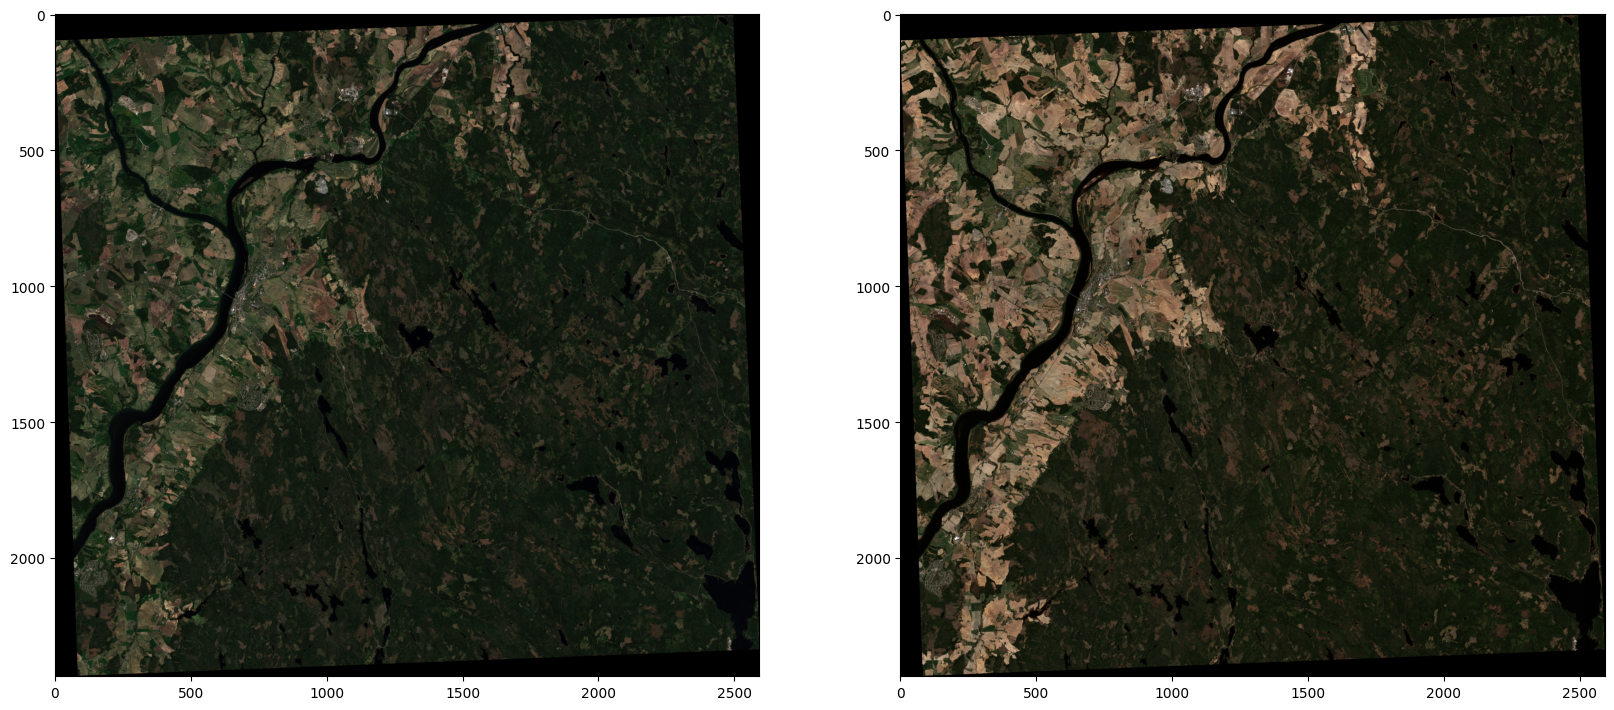

In [32]:
# Plot the resulting images
fig, ax = plt.subplots(1,2, figsize=(20,12))
show(rgb_image1, ax=ax[0])
show(rgb_image2, ax=ax[1])

## NDVI images

In [ ]:
# Fill in the gaps ...
# There is an offset of 1000 to the values
red_2021 = (img1.read(...) - ...).astype(int)
red_2021[red_2021<0] = 0
red_2022 = (img2.read(...) - ...).astype(int)
red_2022[red_2022<0] = 0

nir_2021 = (img1.read(...) - ...).astype(int)
nir_2021[nir_2021<0] = 0
nir_2022 = (img2.read(...) - ...).astype(int)
nir_2022[nir_2022<0] = 0


In [33]:
##
# There is an offset of 1000 to the values
red_2021 = (img1.read(3) - 1000.0).astype(int)
red_2021[red_2021<0] = 0
red_2022 = (img2.read(3) - 1000.0).astype(int)
red_2022[red_2022<0] = 0

nir_2021 = (img1.read(4) - 1000.0).astype(int)
nir_2021[nir_2021<0] = 0
nir_2022 = (img2.read(4) - 1000.0).astype(int)
nir_2022[nir_2022<0] = 0

print(np.unique(red_2022))
print(np.unique(red_2021))
print(np.unique(nir_2022))
print(np.unique(nir_2021))


[   0    1    2 ... 7920 8072 9144]
[   0    1    2 ... 7392 7456 7840]
[    0     1     2 ...  8808  9392 12048]
[   0    1    2 ... 7272 7960 8424]


In [34]:
# Then we can calculate the NDVI
# Fill in the gaps
ndvi_2021 = (...)/(... + 1e-6)
ndvi_2022 = (...)/(... + 1e-6)

# Are you getting values that make sense?

TypeError: unsupported operand type(s) for +: 'ellipsis' and 'float'

In [35]:
##
# Then we can calculate the NDVI
ndvi_2021 = (nir_2021-red_2021)/(nir_2021+red_2021 + 1e-6)
ndvi_2022 = (nir_2022-red_2022)/(nir_2022+red_2022 + 1e-6)

print(np.unique(ndvi_2021))
print(np.unique(ndvi_2022))

[-0.99999999 -0.99999999 -0.99999999 ...  0.99999999  0.99999999
  0.99999999]
[-0.99999999 -0.99999998 -0.99999998 ...  0.99999999  1.
  1.        ]


In [36]:
# Mean NDVI
print("Mean NDVI in 2021:", ndvi_2021.mean())
print("Mean NDVI in 2022:", ndvi_2022.mean())

Mean NDVI in 2021: 0.5801126163006355
Mean NDVI in 2022: 0.5273373954815297


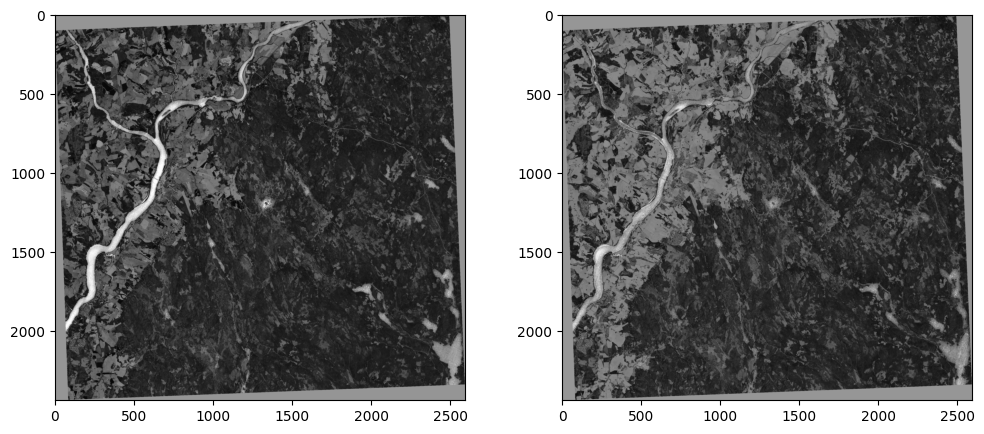

In [37]:
# And let's plot the NDVI in grayscale
# Higher value gives darker color
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(ndvi_2021, cmap='Grays')
ax[1].imshow(ndvi_2022, cmap='Grays')

## Let's look at the difference

We expect the health of the vegetation to be better in 2021, because of the drought in 2022. The NDVI should then be higher for 2021 than for 2022.

We should then expect the difference ndvi_2021 - ndvi_2022 to be mostly positive.

Let's check if that is the case.

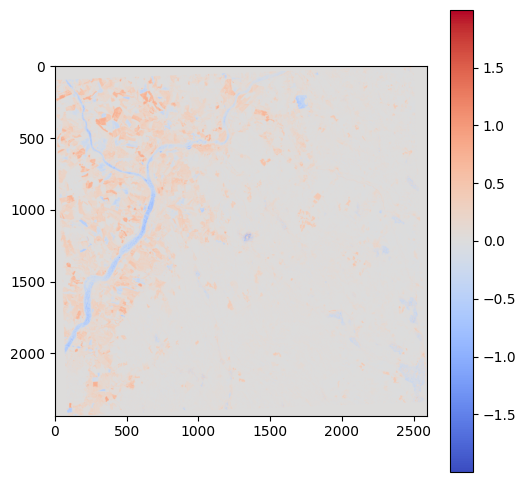

In [38]:
# Plotting the NDVI difference

diff = ndvi_2021 - ndvi_2022
fig, ax = plt.subplots(1, figsize=(6,6))
pic = ax.imshow(diff, norm=matplotlib.colors.CenteredNorm(),cmap = cm.coolwarm)
fig.colorbar(pic, ax=ax)

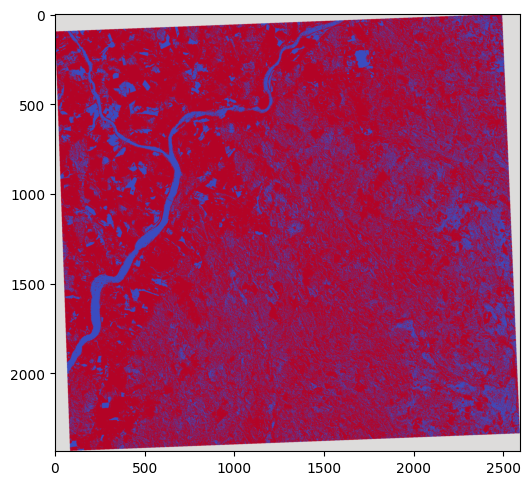

In [39]:
diff_binary = diff
diff_binary[diff_binary>0]=1
diff_binary[diff_binary<0]=-1
fig, ax = plt.subplots(1, figsize=(6,6))
pic = ax.imshow(diff_binary, norm=matplotlib.colors.CenteredNorm(),cmap = cm.coolwarm)

## Save the NDVI difference as a Geotiff

In [42]:
# Open one of the orginal geotiffs, so we can copy the metadata from it
with rasterio.open('/content/drive/MyDrive/S2Intro-data/may2021_r10_masked.tif') as src:
    out_image = diff
    out_meta = src.meta.copy()
    # Update the metadata that are different for our new image
    out_meta.update({
        "driver": "GTiff",
        "count": 1, #only one band instead of 12
        "dtype": "float64", #float instead of int
    })
# Use rasterio to write the numpy array into a geotiff
# using the defined metadata
with rasterio.open("/content/drive/MyDrive/S2Intro-data/NDVI_diff.tiff", "w", **out_meta) as dest:
    dest.write(diff, indexes=1)